In [2]:
from shapely.geometry import Point, GeometryCollection, MultiPolygon, Polygon
from simulator.map_utils import create_regions
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as M
import numpy as np
from model.NetworkGraph import CompleteGraph
from model.NodeClass import Node
from model.LinkClass import Link
from model.NetworkGraphPlots import NodeDegreeHeatMapPlot
from numpy import random

In [3]:
graph = CompleteGraph.of_sources("../Passion_Xtreme_III.mat", "../NameTypes.xlsx")

Discarded nodes: 39
Discarded links: 0
Links: 174
Nodes: 154

*-*-* Printing information about the imported network *-*-*

Num nodes: 154
Num links: 174
Num HL4: 20
Num HL5: 134
Average distance: 2.58
Max distance (km): 22.00
Min distance (km): 0.18
Average degree: 2.27
Min degree: 1
Max degree: 10
Average degree HL4: 1.95
Average degree HL5: 2.32
Total bidirectional link length (km): 448.84


[(0.0, 0.0), (0.0, 98.53143101823554), (95.58191009784183, 98.53143101823554), (95.58191009784183, 0.0), (0.0, 0.0)]


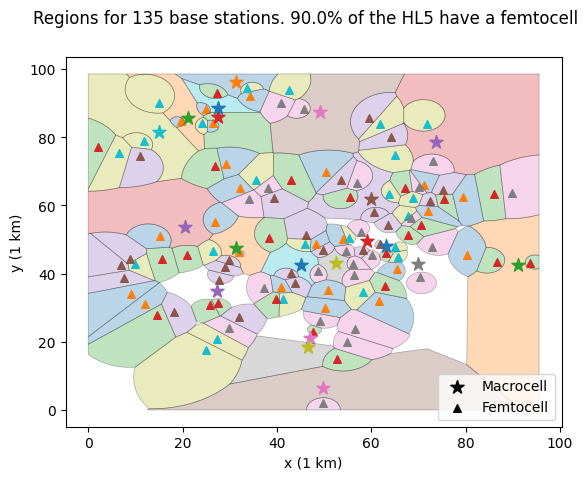

In [10]:
# Suponemos que todos los nodos HL5 tienen una femtocelda y todos los nodos HL4 tienen una macrocelda
# Pasamos todas las coordenadas de los nodos a la lista, y la p_tx será 40 para los HL4 (macrocelda) y 0.1 para las femtoceldas

celdas = []
assocciated_nodes = []
p_tx_fem = 0.1
p_tx_macro = 1
scaling_factor = 1
prob_fem = 0.9
for node in graph.nodes:
    if node.type == "HL4":
        # celdas.append((node.pos[0] * scaling_factor, node.pos[1] * scaling_factor, p_tx_fem))
        assocciated_nodes.append(node)
    elif random.rand() < prob_fem:
        # celdas.append((node.pos[0] * scaling_factor, node.pos[1] * scaling_factor, p_tx_macro))
        assocciated_nodes.append(node)

assocciated_nodes = sorted(assocciated_nodes, key=lambda x: x.type == "HL4", reverse=True)
for node in assocciated_nodes:
    if node.type == "HL4":
        celdas.append((node.pos[0] * scaling_factor, node.pos[1] * scaling_factor, p_tx_macro))
    else:
        celdas.append((node.pos[0] * scaling_factor, node.pos[1] * scaling_factor, p_tx_fem))


alpha_loss = 4
base_area = [(x * scaling_factor, y * scaling_factor) for x, y in graph.network_polygon_bounds]
print(base_area)

regions = create_regions(len(celdas), np.array(celdas), alpha_loss, polygon_bounds=base_area)


# Plot each region with a different color
fig, ax = plt.subplots()

colors = ['red', 'blue', 'green']
for i in range(len(regions)-1, -1, -1):
    region = regions[i]
    if isinstance(region, Polygon):
        x, y = region.exterior.coords.xy
        ax.fill(x, y, alpha=0.3, edgecolor='black', linewidth=0.5)

        
    # Add the base stations to the plot
    node_assoc = assocciated_nodes[i]
    shape = "*" if node_assoc.type == "HL4" else "^"
    size = 100 if node_assoc.type == "HL4" else 30
    ax.scatter(node_assoc.pos[0] * scaling_factor, node_assoc.pos[1] * scaling_factor, marker=shape, s=size)
    
ax.set_xlabel(f"x ({scaling_factor} km)")
ax.set_ylabel(f"y ({scaling_factor} km)")
fig.suptitle(f"Regions for {len(celdas)} base stations. {prob_fem * 100}% of the HL5 have a femtocell")
# Add legend for cell types
ax.scatter([], [], marker="*", s=100, label="Macrocell", color='black')
ax.scatter([], [], marker="^", s=30, label="Femtocell", color='black')
ax.legend()

plt.show()